In [2]:
import pandas as pd
import pandas as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train=pd.read_csv("./data/train_data.csv")
test=pd.read_csv("./data/test_data.csv")
sub=pd.read_csv("./data/sample_submission.csv")

print(f"train shape : {train.shape}")
print(f"test shape : {test.shape}")
print(f"sub shape : {sub.shape}")

train shape : (2266586, 6)
test shape : (260114, 6)
sub shape : (744, 2)


In [4]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [5]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [6]:
sub

,id,prediction
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
739,739,0.5
740,740,0.5
741,741,0.5
742,742,0.5


## 0. Data 파악

In [7]:
_data=pd.concat([train, test])
_user=_data["userID"].nunique()
_assessmentItemID=_data["assessmentItemID"].nunique()
_testId=_data["testId"].nunique()
_records=len(_data)-len(sub)

In [8]:
print(f"전체 데이터에 유저는 {_user}명, 문항은 {_assessmentItemID}개 존재하고, 테스트 기록은 {_records}개 존재합니다")
print(f'유저와 문항 간 행렬을 모두 채우려면 {_user*_assessmentItemID}개가 필요합니다.')
print(f'현재 있는 테스트 기록은 {_records}이므로 {(1-_records/(_user*_assessmentItemID))*100}%만큼 희소행렬 입니다.')

전체 데이터에 유저는 7442명, 문항은 9454개 존재하고, 테스트 기록은 2525956개 존재합니다
유저와 문항 간 행렬을 모두 채우려면 70356668개가 필요합니다.
현재 있는 테스트 기록은 2525956이므로 96.40978449974351%만큼 희소행렬 입니다.


In [9]:
print(f"train의 유저는 {train['userID'].nunique()}명, test의 유저는 {test['userID'].nunique()}명 존재합니다")
print(f"test의 유저 중 {(len(set(test['userID'])&set(train['userID']))/test['userID'].nunique())*100}%가 train에 존재합니다")

train의 유저는 6698명, test의 유저는 744명 존재합니다
test의 유저 중 0.0%가 train에 존재합니다


In [10]:
print(f"train의 문항은 {train['assessmentItemID'].nunique()}개, test의 문항은 {test['assessmentItemID'].nunique()}개 존재합니다")
print(f"test의 문항 중 {(len(set(test['assessmentItemID'])&set(train['assessmentItemID']))/test['assessmentItemID'].nunique())*100}%가 train에 존재합니다")

train의 문항은 9454개, test의 문항은 9454개 존재합니다
test의 문항 중 100.0%가 train에 존재합니다


- user에 대한 cold start 문제 고려 필요

In [11]:
train.isna().sum()

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64

In [12]:
test.isna().sum()

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64

- train, test 모두 결측치 없음

In [145]:
test=test[test["answerCode"]!=-1]

## 1. USER 관련

Text(0.5, 1.0, '# of records by test user')

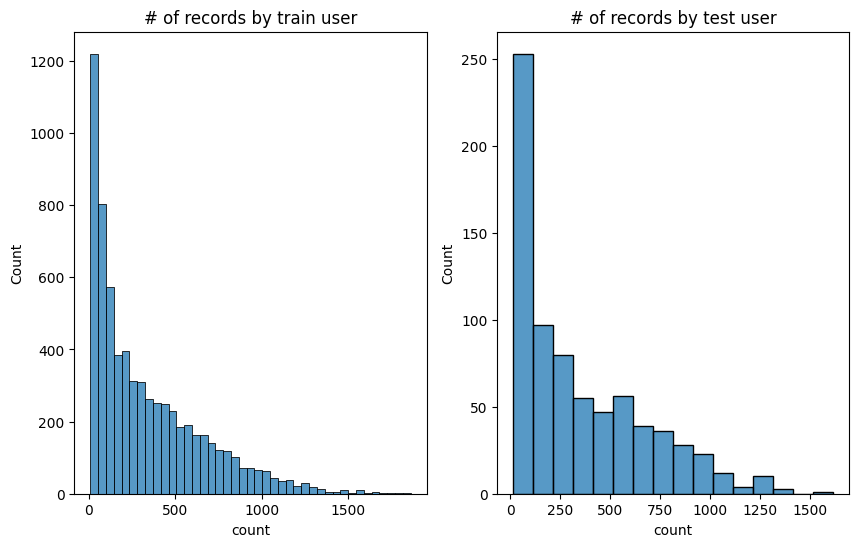

In [146]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['userID'].value_counts())
plt.title("# of records by train user")

plt.subplot(1, 2, 2)
sns.histplot(test['userID'].value_counts())
plt.title("# of records by test user")

**train, test user 대부분 250 문항 이하로 풀었습니다**

Text(0.5, 1.0, 'correct rate by test user')

<Figure size 1500x600 with 0 Axes>

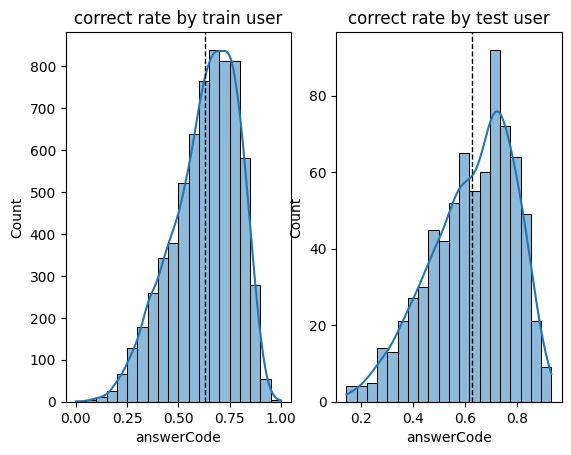

In [156]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

train_cr=train.groupby("userID")["answerCode"].mean()
sns.histplot(train_cr, kde=True, ax=axes[0], bins=20)
axes[0].axvline(train_cr.mean(), color='k', linestyle='dashed', linewidth=1)
axes[0].set_title("correct rate by train user")

test_cr=test.groupby("userID")["answerCode"].mean()
sns.histplot(test_cr, kde=True, ax=axes[1],  bins=20)
axes[1].axvline(test_cr.mean(), color='k', linestyle='dashed', linewidth=1)
axes[1].set_title("correct rate by test user")

**유저별 정답률 역시 비슷한 분포를 보입니다**

In [148]:
print(f"train내 유저는 문항당 평균 {train.groupby(['userID', 'assessmentItemID'])['Timestamp'].count().mean()}회 풀었습니다")
print(f"test내 유저는 문항당 평균 {test.groupby(['userID', 'assessmentItemID'])['Timestamp'].count().mean()}회 풀었습니다")

train내 유저는 문항당 평균 1.0206936490631275회 풀었습니다
test내 유저는 문항당 평균 1.0157788995891768회 풀었습니다


## 2. assessmentItem/Test 관련

Text(0.5, 1.0, '#of items in test')

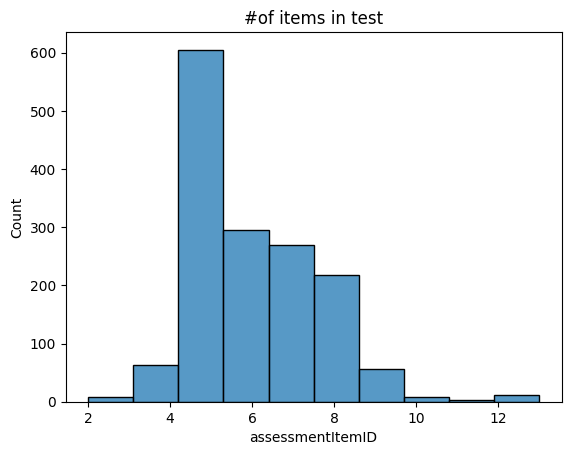

In [149]:
sns.histplot(train.groupby(["testId"])["assessmentItemID"].apply(lambda x: len(set(x))), bins=10)
plt.title("#of items in test")

**테스트 내 문항은 대부분 5개 정도로 많지 않습니다**

Text(0.5, 1.0, "#of records by test's test")

<Figure size 1500x600 with 0 Axes>

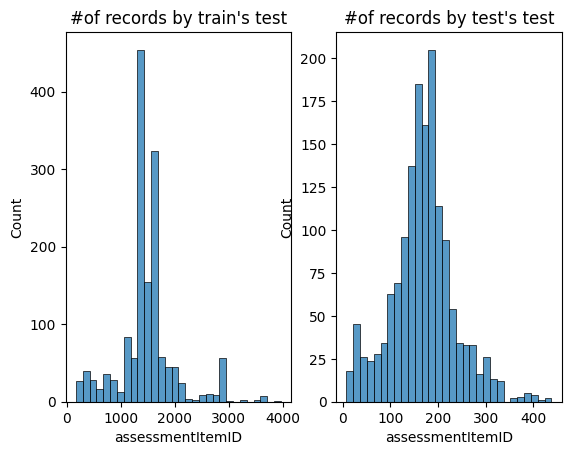

In [213]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby(["testId"]).count().iloc[:, 1], ax=axes[0], bins=30)
axes[0].set_title("#of records by train's test")
             
sns.histplot(test.groupby(["testId"]).count().iloc[:, 1], ax=axes[1], bins=30)
axes[1].set_title("#of records by test's test")

**압도적으로 많이 풀어본 시험지가 일부 있습니다**

Text(0.5, 1.0, "avg correct rate by test's test")

<Figure size 1500x600 with 0 Axes>

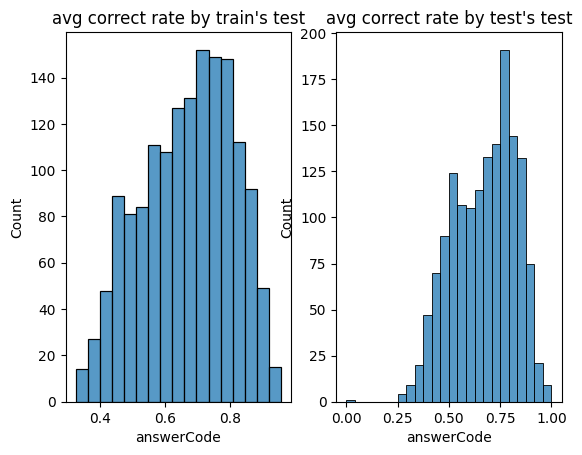

In [150]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby(["testId"])["answerCode"].mean(), ax=axes[0])
axes[0].set_title("avg correct rate by train's test")
             
sns.histplot(test.groupby(["testId"])["answerCode"].mean(), ax=axes[1])
axes[1].set_title("avg correct rate by test's test")

**test data내 정답률이 0인 테스트 존재 (test data내 testId는 A080000064에 대한 기록은 전부 오답입니다)**

In [129]:
test[test["testId"]=="A080000064"]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
6043,45,A080064001,A080000064,0,2020-06-17 07:32:04,4970
6044,45,A080064002,A080000064,0,2020-06-17 07:32:07,4970
6045,45,A080064003,A080000064,0,2020-06-17 07:32:12,4970
6046,45,A080064004,A080000064,0,2020-06-17 07:32:14,4971
6047,45,A080064005,A080000064,0,2020-06-17 07:32:16,4971
6048,45,A080064006,A080000064,0,2020-06-17 07:32:18,4971
6049,45,A080064007,A080000064,0,2020-06-17 07:32:21,4971
6050,45,A080064008,A080000064,0,2020-06-17 07:32:24,4971


In [930]:
train[train["testId"]=="A080000064"]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first,...,weekday,hour,elapse,elapse_bin,repeat,user_correct_answer,user_total_answer,user_acc,item_mean,user_tag_mean
38885,51,A080064008,A080000064,0,2020-04-29 17:10:36,4971,0,64,8,8,...,2,17,NaN,10,1,570.0,656,0.868902,0.428571,0.916667
38886,51,A080064001,A080000064,1,2020-04-29 17:12:35,4970,0,64,1,8,...,2,17,119.0,3,1,570.0,657,0.867580,0.653061,0.857143
38887,51,A080064002,A080000064,1,2020-04-29 17:13:34,4970,0,64,2,8,...,2,17,59.0,2,1,571.0,658,0.867781,0.551020,0.857143
38888,51,A080064003,A080000064,0,2020-04-29 17:15:37,4970,0,64,3,8,...,2,17,123.0,3,1,572.0,659,0.867982,0.204082,0.857143
38889,51,A080064004,A080000064,1,2020-04-29 17:18:21,4971,0,64,4,8,...,2,17,164.0,3,1,572.0,660,0.866667,0.510204,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2182362,5557,A080064004,A080000064,0,2020-08-14 07:58:07,4971,0,64,4,8,...,4,7,3.0,1,1,15.0,42,0.357143,0.510204,0.166667
2182363,5557,A080064005,A080000064,0,2020-08-14 07:58:09,4971,0,64,5,8,...,4,7,2.0,1,1,15.0,43,0.348837,0.612245,0.166667
2182364,5557,A080064006,A080000064,0,2020-08-14 07:58:11,4971,0,64,6,8,...,4,7,2.0,1,1,15.0,44,0.340909,0.408163,0.166667
2182365,5557,A080064007,A080000064,0,2020-08-14 07:58:13,4971,0,64,7,8,...,4,7,2.0,1,1,15.0,45,0.333333,0.530612,0.166667


Text(0.5, 1.0, "#of records by test's Item")

<Figure size 1500x600 with 0 Axes>

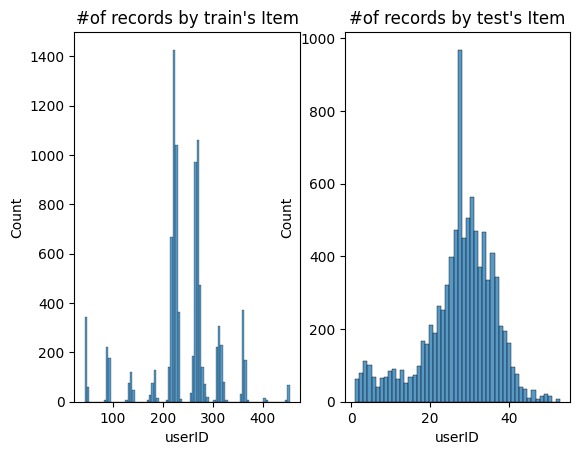

In [220]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby(["assessmentItemID"]).count().iloc[:, 0], ax=axes[0])
axes[0].set_title("#of records by train's Item")
             
sns.histplot(test.groupby(["assessmentItemID"]).count().iloc[:, 0], ax=axes[1])
axes[1].set_title("#of records by test's Item")

Text(0.5, 1.0, "avg correct rate by test's item")

<Figure size 1500x600 with 0 Axes>

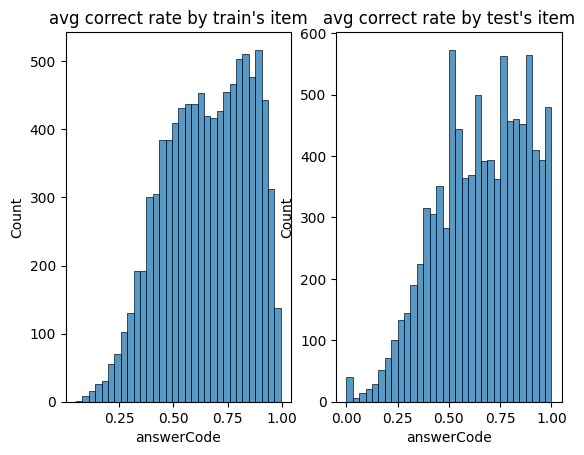

In [931]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby(["assessmentItemID"])["answerCode"].mean(), ax=axes[0])
axes[0].set_title("avg correct rate by train's item")
             
sns.histplot(test.groupby(["assessmentItemID"])["answerCode"].mean(), ax=axes[1])
axes[1].set_title("avg correct rate by test's item")

**train보다 test data내 정답률이 1인 문항이 더 많습니다 -> train과 test의 문항은 모두 같으므로 test data내 문제를 잘 푸는 user가 더 많다고 가정할 수 있음**

In [329]:
train["testid_first"]=train["testId"].apply(lambda x: x[2])

<Axes: ylabel='testid_first'>

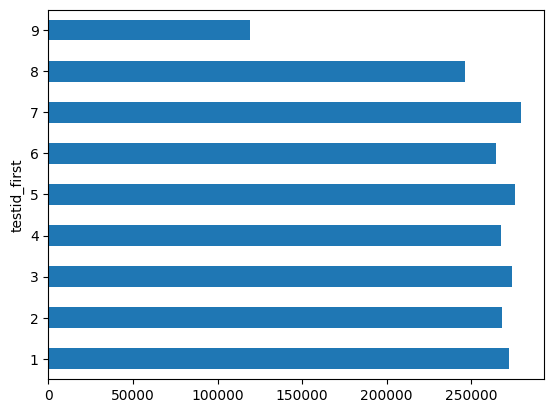

In [949]:
train.groupby("testid_first").count().iloc[:, 0].plot.barh()

In [935]:
train.groupby("testid_first")["answerCode"].mean()

testid_first
1    0.800876
2    0.737593
3    0.702238
4    0.684056
5    0.658208
6    0.709232
7    0.521876
8    0.502598
9    0.449948
Name: answerCode, dtype: float64

<Axes: ylabel='testid_first'>

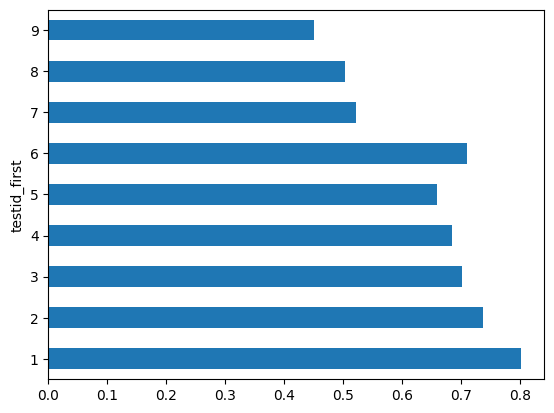

In [942]:
train.groupby("testid_first")["answerCode"].mean().plot.barh()

**testid의 2번째 번호가 높을수록 정답률이 낮습니다 => 난이도와 연관이 있다고 추측할 수 있음**

<Axes: ylabel='testid_first'>

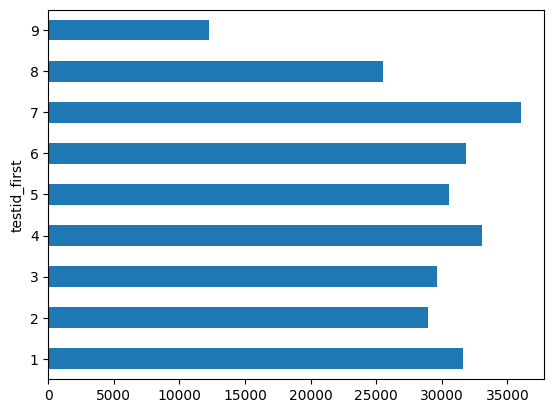

In [950]:
test["testid_first"]=test["testId"].apply(lambda x: x[2])
test.groupby("testid_first").count().iloc[:, 0].plot.barh()

<Axes: ylabel='testid_sec'>

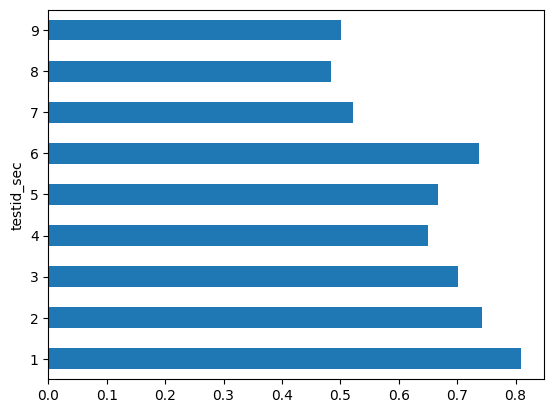

In [951]:
test.groupby("testid_sec")["answerCode"].mean().plot.barh()

**test data도 마찬가지입니다**

In [961]:
train["testid_rest"]=train["testId"].apply(lambda x: x[-3:])
train.groupby(["testid_rest"]).count()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,itemseq,testid_first,testid_last,...,weekday,hour,elapse,elapse_bin,repeat,user_correct_answer,user_total_answer,user_acc,item_mean,user_tag_mean
testid_rest,,,,,,,,,,,,,,,,,,,,,
001,14911,14911,14911,14911,14911,14911,14911,14911,14911,14911,...,14911,14911,12504,14911,14911,14260,14911,14260,14911,14911
002,12390,12390,12390,12390,12390,12390,12390,12390,12390,12390,...,12390,12390,10344,12390,12390,12062,12390,12062,12390,12390
003,16970,16970,16970,16970,16970,16970,16970,16970,16970,16970,...,16970,16970,14367,16970,16970,16744,16970,16744,16970,16970
004,12332,12332,12332,12332,12332,12332,12332,12332,12332,12332,...,12332,12332,10314,12332,12332,12194,12332,12194,12332,12332
005,16325,16325,16325,16325,16325,16325,16325,16325,16325,16325,...,16325,16325,13721,16325,16325,16112,16325,16112,16325,16325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,2596,2596,2596,2596,2596,2596,2596,2596,2596,2596,...,2596,2596,2087,2596,2596,2588,2596,2588,2596,2596
195,4417,4417,4417,4417,4417,4417,4417,4417,4417,4417,...,4417,4417,3642,4417,4417,4411,4417,4411,4417,4417
196,1304,1304,1304,1304,1304,1304,1304,1304,1304,1304,...,1304,1304,1034,1304,1304,1303,1304,1303,1304,1304


<Axes: xlabel='testid_rest', ylabel='userID'>

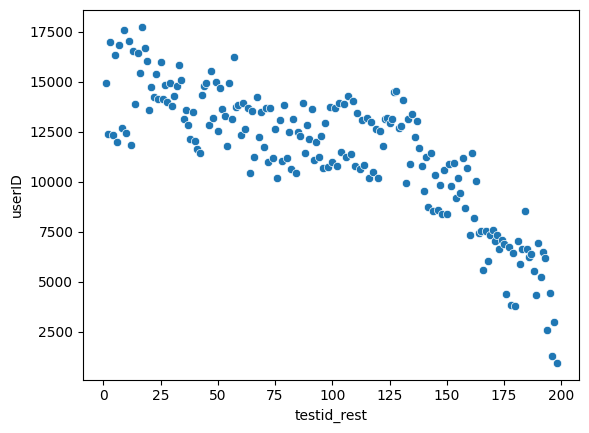

In [954]:
sns.scatterplot(train.groupby(["testid_rest"]).count()["userID"])

In [963]:
train.groupby(["testid_first"])["testid_rest"].agg([min, max])

,min,max
testid_first,,
1,001,192
2,001,195
3,001,198
4,001,198
5,001,193
6,001,186
7,001,164
8,001,138
9,001,074


**testid_first가 높을수록 포함된 시험지 수가 적어 testid_rest가 작습니다**

<Axes: xlabel='testid_rest', ylabel='answerCode'>

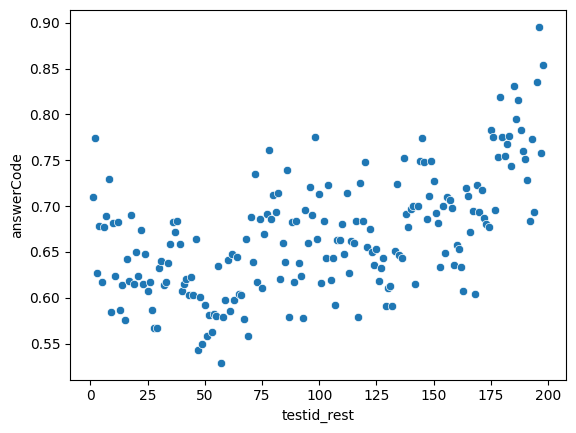

In [953]:
sns.scatterplot(train.groupby(["testid_rest"])["answerCode"].mean())

**testid의 마지막 3자리가 커질수록 개수는 적고, 정답률이 높습니다**

**난이도가 높을수록(testid_first) testid_rest가 작기 때문**

<Axes: xlabel='testid_rest', ylabel='answerCode'>

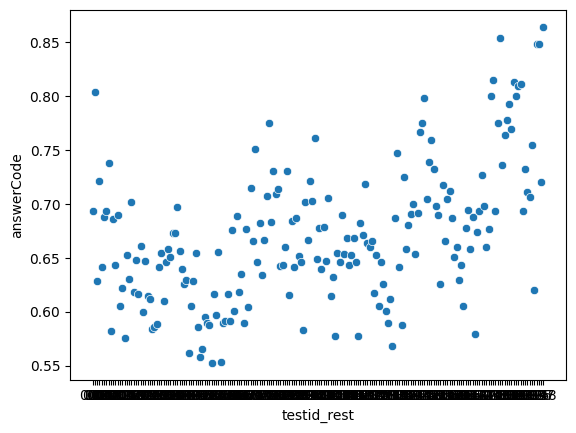

In [962]:
test["testid_rest"]=test["testId"].apply(lambda x: x[-3:])
sns.scatterplot(test.groupby(["testid_rest"])["answerCode"].mean())

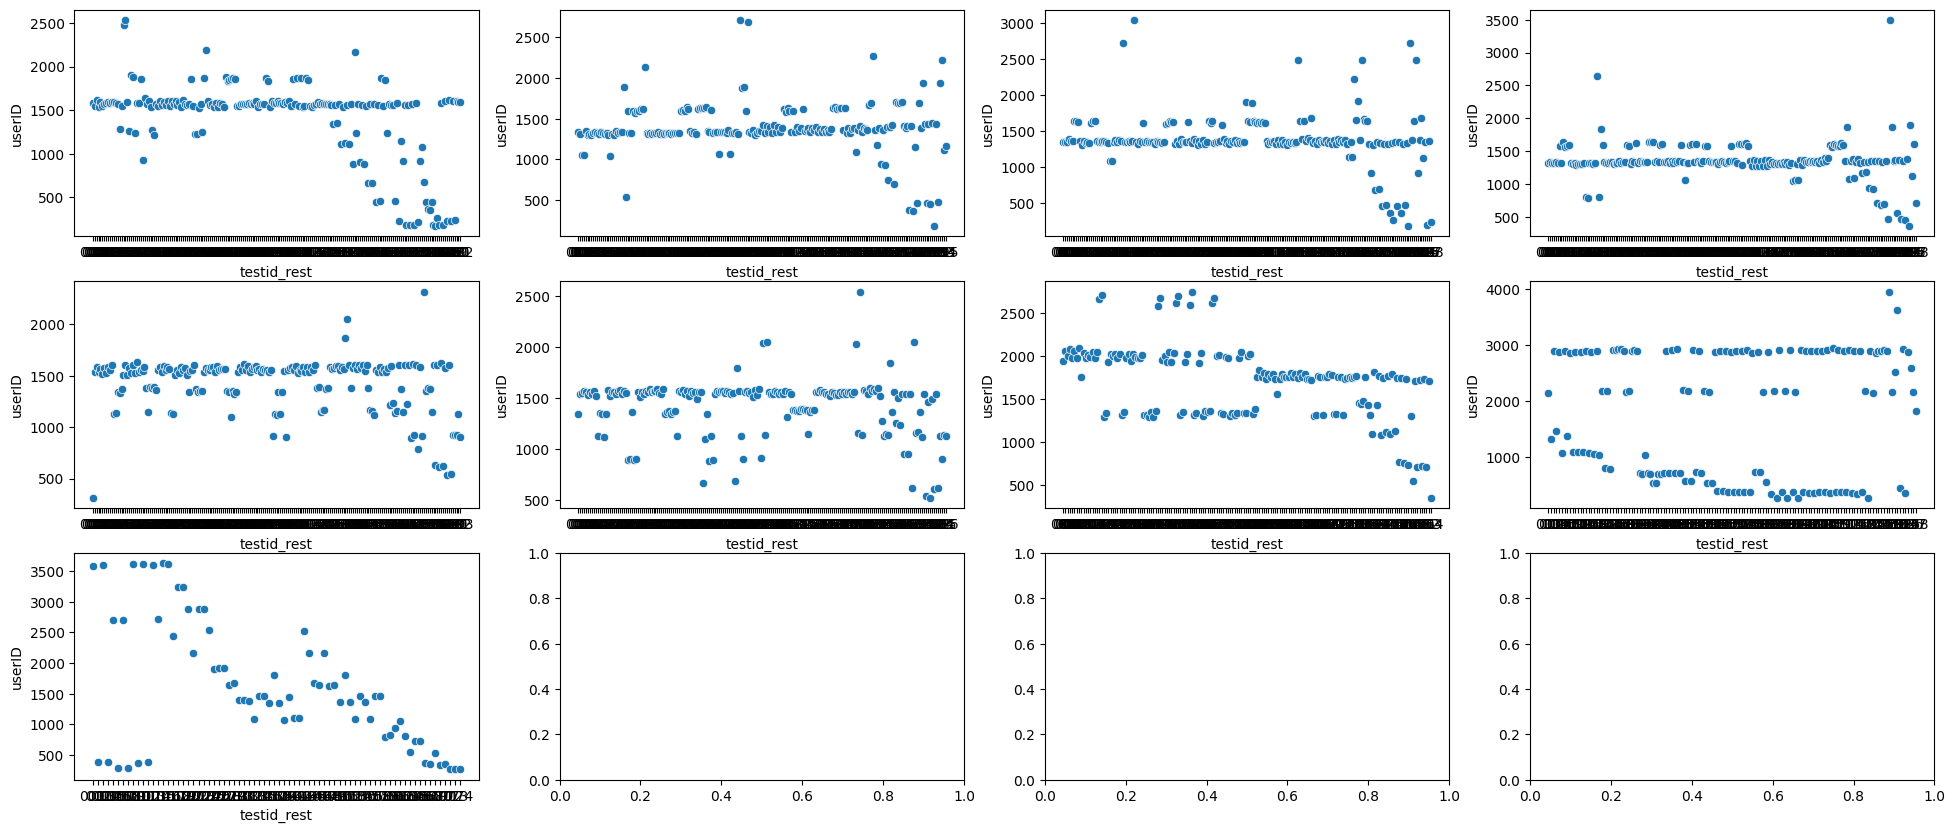

In [376]:
fig, ax=plt.subplots(3, 4, figsize=(24, 10))
for i, _ax in zip(range(1, 10), ax.flatten()):
    sns.scatterplot(train[train["testid_first"]==str(i)].groupby(["testid_rest"])["userID"].count(), ax=_ax)

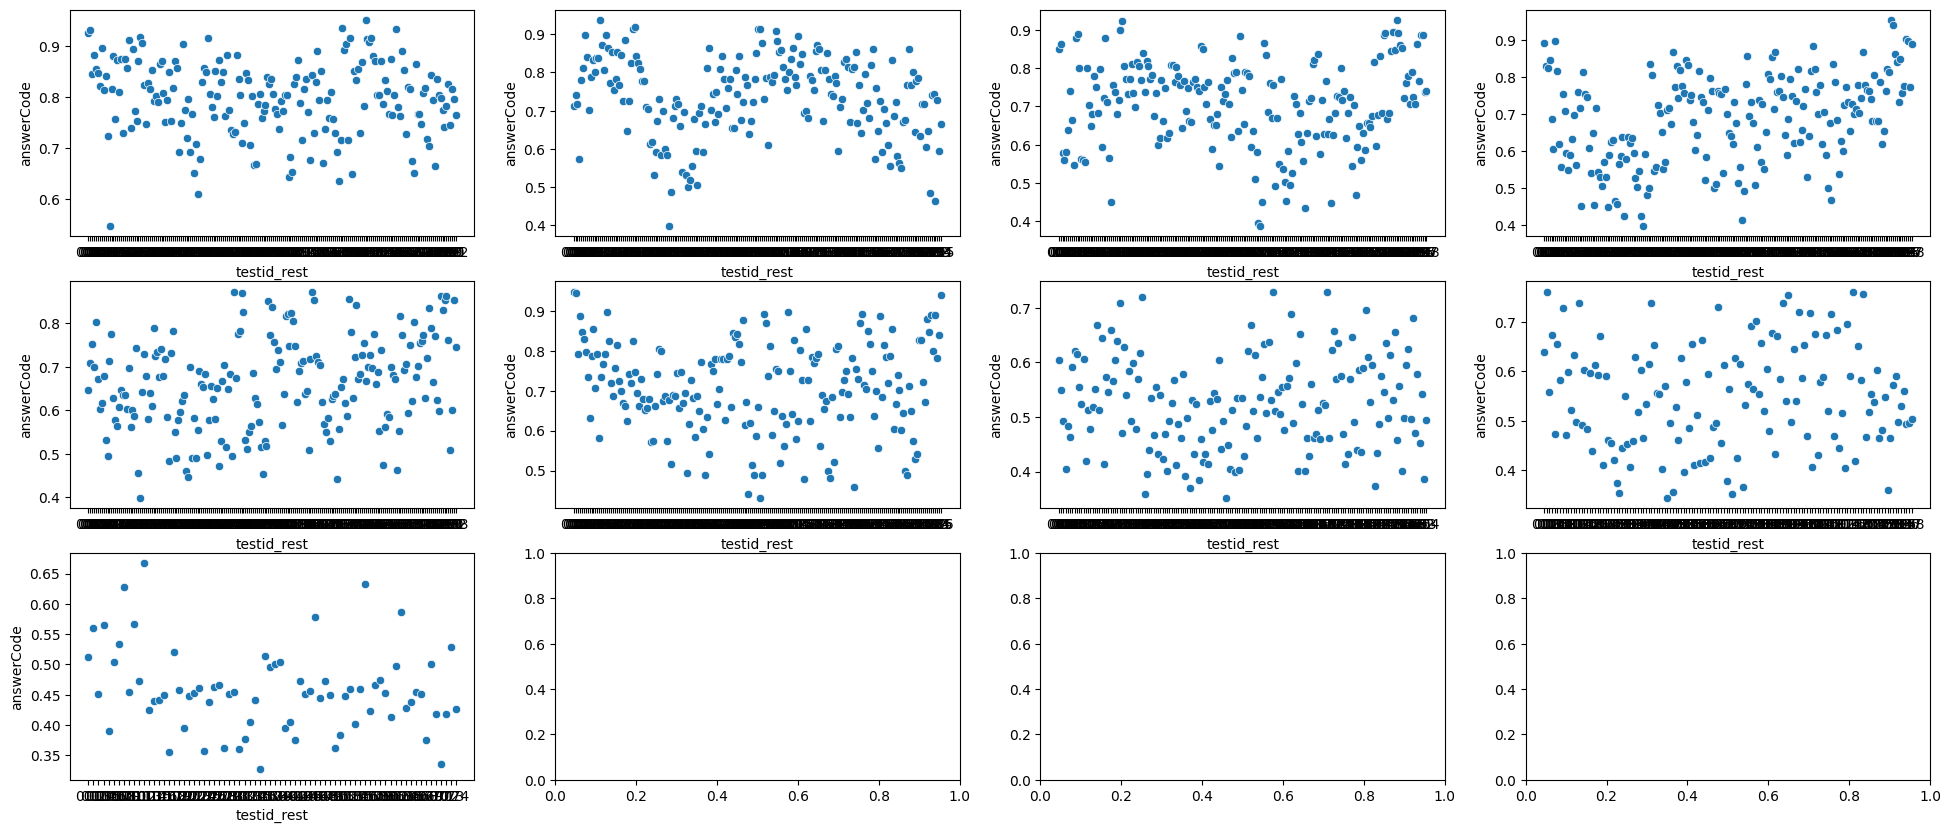

In [377]:
fig, ax=plt.subplots(3, 4, figsize=(24, 10))
for i, _ax in zip(range(1, 10), ax.flatten()):
    sns.scatterplot(train[train["testid_first"]==str(i)].groupby(["testid_rest"])["answerCode"].mean(), ax=_ax)

**testid 그룹 내에서(testid_first) id 마지막 3자리는 의미를 찾기 어렵습니다(9번만 분포가 다름?)**

In [338]:
train["testid_last"]=train["testId"].apply(lambda x: x[-1])
train.groupby(["testid_last"]).count()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first
testid_last,,,,,,,,,,
0,200111,200111,200111,200111,200111,200111,200111,200111,200111,200111
1,247657,247657,247657,247657,247657,247657,247657,247657,247657,247657
2,213197,213197,213197,213197,213197,213197,213197,213197,213197,213197
3,249769,249769,249769,249769,249769,249769,249769,249769,249769,249769
4,215019,215019,215019,215019,215019,215019,215019,215019,215019,215019
5,242085,242085,242085,242085,242085,242085,242085,242085,242085,242085
6,207763,207763,207763,207763,207763,207763,207763,207763,207763,207763
7,247545,247545,247545,247545,247545,247545,247545,247545,247545,247545
8,209236,209236,209236,209236,209236,209236,209236,209236,209236,209236


In [340]:
train.groupby(["testid_last"])["answerCode"].mean()

testid_last
0    0.672722
1    0.646891
2    0.666693
3    0.628537
4    0.668290
5    0.646620
6    0.672988
7    0.638619
8    0.677340
9    0.637854
Name: answerCode, dtype: float64

In [341]:
train["testid_thd"]=train["testId"].apply(lambda x: x[-2])
train.groupby(["testid_thd"]).count()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first,testid_last
testid_thd,,,,,,,,,,,
0,257671,257671,257671,257671,257671,257671,257671,257671,257671,257671,257671
1,272347,272347,272347,272347,272347,272347,272347,272347,272347,272347,272347
2,274486,274486,274486,274486,274486,274486,274486,274486,274486,274486,274486
3,260710,260710,260710,260710,260710,260710,260710,260710,260710,260710,260710
4,232875,232875,232875,232875,232875,232875,232875,232875,232875,232875,232875
5,237026,237026,237026,237026,237026,237026,237026,237026,237026,237026,237026
6,206081,206081,206081,206081,206081,206081,206081,206081,206081,206081,206081
7,185973,185973,185973,185973,185973,185973,185973,185973,185973,185973,185973
8,181872,181872,181872,181872,181872,181872,181872,181872,181872,181872,181872


In [342]:
train.groupby(["testid_thd"])["answerCode"].mean()

testid_thd
0    0.661972
1    0.644678
2    0.630509
3    0.653523
4    0.647901
5    0.621670
6    0.631300
7    0.692450
8    0.702192
9    0.690565
Name: answerCode, dtype: float64

In [386]:
train["testid_sec"]=train["testId"].apply(lambda x: x[-3])
train.groupby(["testid_sec"]).count()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_rest,itemseq,testid_first,testid_last,testid_thd,testid_fth
testid_sec,,,,,,,,,,,,
0,1335224,1335224,1335224,1335224,1335224,1335224,1335224,1335224,1335224,1335224,1335224,1335224
1,931362,931362,931362,931362,931362,931362,931362,931362,931362,931362,931362,931362


In [387]:
train.groupby(["testid_sec"])["answerCode"].mean()

testid_sec
0    0.635048
1    0.682091
Name: answerCode, dtype: float64

**testid rest의 각 자리에는 의미가 없어 보입니다**

In [196]:
test.groupby(["assessmentItemID"])["answerCode"].mean().sort_values()[-20:]

assessmentItemID
A070150004    1.0
A020068001    1.0
A070150003    1.0
A070150001    1.0
A060082003    1.0
A050135002    1.0
A050168002    1.0
A020045003    1.0
A060076004    1.0
A060076001    1.0
A020034006    1.0
A060074004    1.0
A060074003    1.0
A050150001    1.0
A060071001    1.0
A060070002    1.0
A070146001    1.0
A050154003    1.0
A050138002    1.0
A090074006    1.0
Name: answerCode, dtype: float64

In [198]:
test[test["assessmentItemID"]=="A070150004"]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
10812,79,A070150004,A070000150,1,2020-11-23 04:58:49,7863
37100,496,A070150004,A070000150,1,2020-06-09 10:49:19,7863
104561,1348,A070150004,A070000150,1,2020-11-26 04:14:45,7863
111954,1469,A070150004,A070000150,1,2020-10-20 02:35:46,7863
162139,2172,A070150004,A070000150,1,2020-12-19 05:45:39,7863


In [200]:
train[train["assessmentItemID"]=="A070150004"]["answerCode"].mean()

0.7263157894736842

In [312]:
train["itemseq"]=train["assessmentItemID"].apply(lambda x: x[-1])

In [316]:
train.groupby(["itemseq"]).count()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest
itemseq,,,,,,,,
0,5342,5342,5342,5342,5342,5342,5342,5342
1,375107,375107,375107,375107,375107,375107,375107,375107
2,373456,373456,373456,373456,373456,373456,373456,373456
3,371909,371909,371909,371909,371909,371909,371909,371909
4,369705,369705,369705,369705,369705,369705,369705,369705
5,360607,360607,360607,360607,360607,360607,360607,360607
6,197772,197772,197772,197772,197772,197772,197772,197772
7,127121,127121,127121,127121,127121,127121,127121,127121
8,67150,67150,67150,67150,67150,67150,67150,67150


<Axes: ylabel='itemseq'>

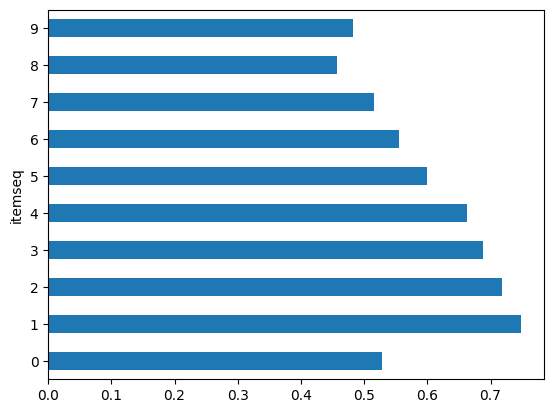

In [964]:
train.groupby(["itemseq"])["answerCode"].mean().plot.barh()

**한 시험지에서 뒷 문제로 갈수록 정답률이 떨어집니다**

In [417]:
train=train.drop(["testid_fth"], axis=1)
train.iloc[:, -7:]=train.iloc[:, -7:].astype(int)

In [418]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first,testid_last,testid_thd
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,1,1,6,1,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,1,2,6,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,1,3,6,1,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,1,4,6,1,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,1,5,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0,71,5,3,1,7
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,165,1,4,5,6
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,165,2,4,5,6
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,165,3,4,5,6


## 3. KnowledgeTag 관련

In [207]:
print(f"train 내 KnowledgeTag는 {train.KnowledgeTag.nunique()}개 존재하고, test내 KnowledgeTag는 {test.KnowledgeTag.nunique()}개 존재합니다")
print(f"train내 존재하지 않는 test의 KnowledgeTag는 {len(set(test.KnowledgeTag)-set(train.KnowledgeTag))}개 입니다")

train 내 KnowledgeTag는 912개 존재하고, test내 KnowledgeTag는 912개 존재합니다
train내 존재하지 않는 test의 KnowledgeTag는 0개 입니다


Text(0.5, 1.0, "#of records by test's Tag")

<Figure size 1500x600 with 0 Axes>

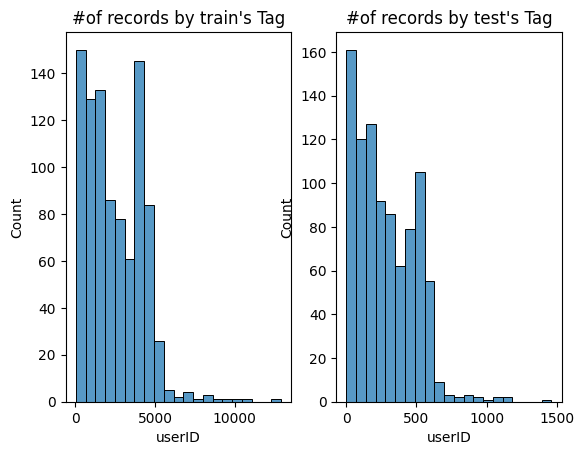

In [228]:
plt.figure(figsize=(15, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby("KnowledgeTag").count().iloc[:, 0], ax=axes[0])
axes[0].set_title("#of records by train's Tag")
             
sns.histplot(test.groupby("KnowledgeTag").count().iloc[:, 0], ax=axes[1])
axes[1].set_title("#of records by test's Tag")

**KnowledgeTag별 빈도수가 상이합니다**

**많이 등장한 KnowledgeTag는 소수**

Text(0.5, 1.0, "avg correct rate by test's tag")

<Figure size 2000x600 with 0 Axes>

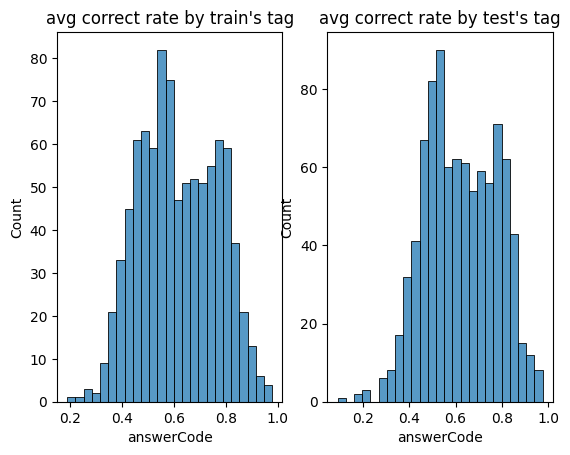

In [572]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2)

sns.histplot(train.groupby(["KnowledgeTag"])["answerCode"].mean(), ax=axes[0], bins=25)
axes[0].set_title("avg correct rate by train's tag")
             
sns.histplot(test.groupby(["KnowledgeTag"])["answerCode"].mean(), ax=axes[1], bins=25)
axes[1].set_title("avg correct rate by test's tag")

In [264]:
traintag_cntmean=pd.concat([train.groupby(["KnowledgeTag"])["answerCode"].mean(), train.groupby("KnowledgeTag").count().iloc[:, 0]], axis=1).reset_index()
traintag_cntmean=traintag_cntmean.rename(columns={"answerCode":"mean", "userID":"cnt"})
traintag_cntmean

,KnowledgeTag,mean,cnt
0,23,0.584444,1800
1,24,0.614525,358
2,25,0.858696,92
3,26,0.614309,2432
4,30,0.536178,539
...,...,...,...
907,11253,0.739374,4282
908,11265,0.676211,454
909,11269,0.557716,2417
910,11270,0.478927,261


<Axes: xlabel='cnt', ylabel='mean'>

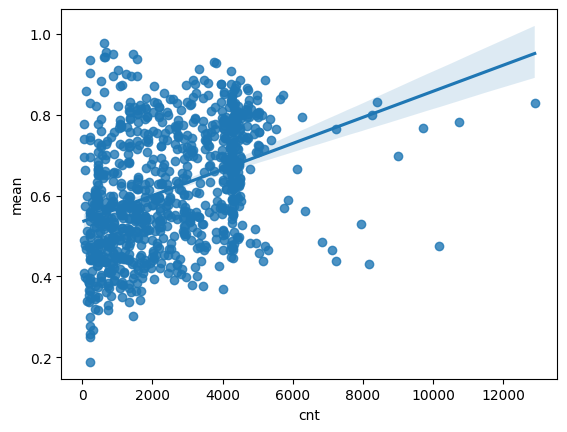

In [268]:
sns.regplot(x="cnt", y="mean", data=traintag_cntmean)

In [269]:
testtag_cntmean=pd.concat([test.groupby(["KnowledgeTag"])["answerCode"].mean(), test.groupby("KnowledgeTag").count().iloc[:, 0]], axis=1).reset_index()
testtag_cntmean=testtag_cntmean.rename(columns={"answerCode":"mean", "userID":"cnt"})
testtag_cntmean

,KnowledgeTag,mean,cnt
0,23,0.670000,200
1,24,0.714286,42
2,25,0.750000,8
3,26,0.584270,267
4,30,0.475410,61
...,...,...,...
907,11253,0.669884,518
908,11265,0.688889,45
909,11269,0.565371,283
910,11270,0.487179,39


<Axes: xlabel='cnt', ylabel='mean'>

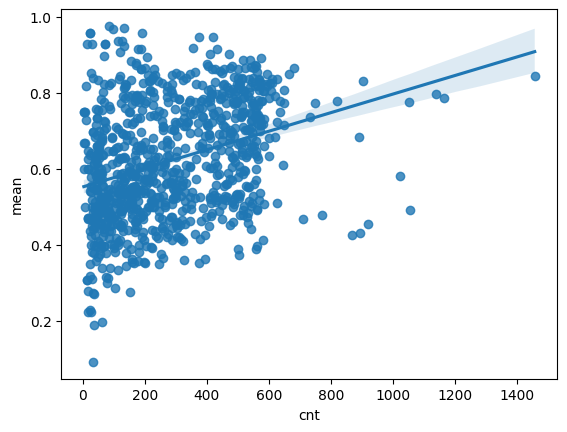

In [389]:
sns.regplot(x="cnt", y="mean", data=testtag_cntmean)

**KnowledgeTag의 빈도는 정답률과 큰 상관이 없어 보입니다**

<Axes: xlabel='KnowledgeTag', ylabel='testid_first'>

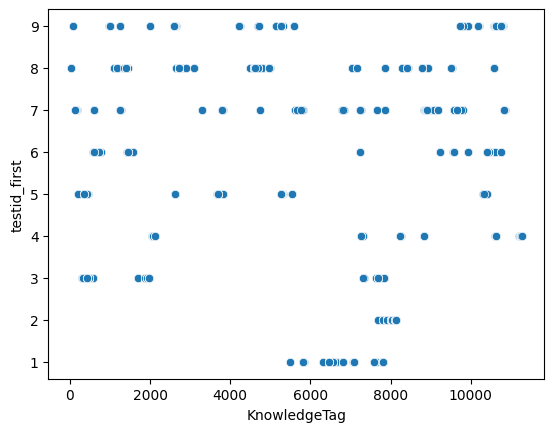

In [438]:
sns.scatterplot(x="KnowledgeTag", y="testid_first", data=train)

In [443]:
train.groupby(["testid_first"])["KnowledgeTag"].apply(lambda x: x.nunique())

testid_first
1     64
2     70
3     85
4     81
5     98
6     93
7    176
8    150
9     96
Name: KnowledgeTag, dtype: int64

**testid 그룹이 높을수록 더 다양한 KnowledgeTag로 이루어져있습니다 -> 정답률이 낮은 이유?**

In [436]:
train.groupby(["KnowledgeTag"])["testid_first"].unique().apply(lambda x: max(x)-min(x)).sort_values()

KnowledgeTag
23       0
7751     0
7781     0
7782     0
7788     0
        ..
2610     0
2611     0
2133     0
11271    0
7863     1
Name: testid_first, Length: 912, dtype: int64

**KnowledgeTag는 7863을 제외하고 하나의 testid_first를 갖습니다**


## 4. Timestamp 관련

In [500]:
train.loc[:, "year"]=train.loc[:,"Timestamp"].dt.year
train.loc[:, "month"]=train.loc[:,"Timestamp"].dt.month
train.loc[:, "day"]=train.loc[:,"Timestamp"].dt.day
train.loc[:, "weekday"]=train.loc[:,"Timestamp"].dt.weekday  #요일 0:월요일~

test.loc[:, "year"]=test.loc[:,"Timestamp"].dt.year
test.loc[:, "month"]=test.loc[:,"Timestamp"].dt.month
test.loc[:, "day"]=test.loc[:,"Timestamp"].dt.day
test.loc[:, "weekday"]=test.loc[:,"Timestamp"].dt.weekday  #요일 0:월요일~

In [494]:
train["year"].value_counts()

year
2020    2266567
2019         19
Name: count, dtype: int64

In [501]:
test["year"].value_counts()

year
2020    259365
2019         5
Name: count, dtype: int64

train, test 모두 대부분이 2020년 기록입니다

Text(0.5, 1.0, "# of records by test's month")

<Figure size 2000x600 with 0 Axes>

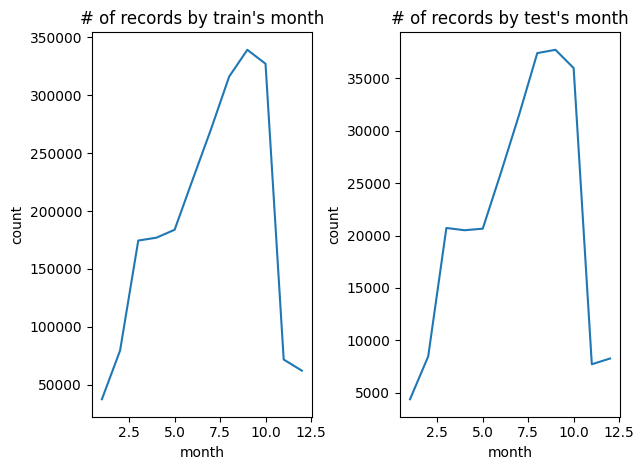

In [515]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2, tight_layout=True)

sns.lineplot(train["month"].value_counts(), ax=axes[0])
axes[0].set_title("# of records by train's month")
             
sns.lineplot(test["month"].value_counts(), ax=axes[1])
axes[1].set_title("# of records by test's month")

**12-3월까지는 풀이 기록이 적습니다 -> 방학기간으로 추측 가능**

Text(0.5, 1.0, "avg correct rate by test's month")

<Figure size 2000x600 with 0 Axes>

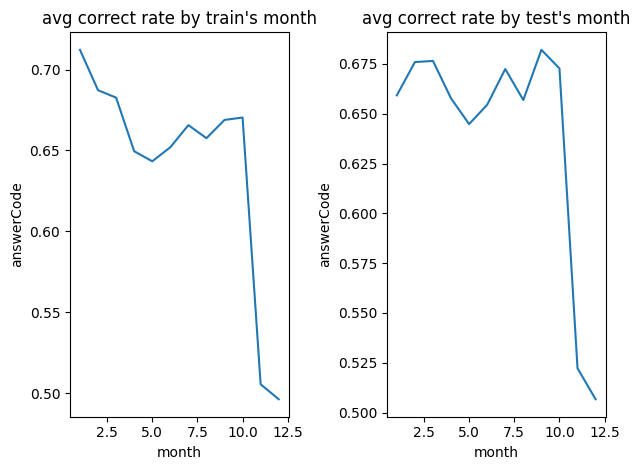

In [509]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2, tight_layout=True)

sns.lineplot(train.groupby(["month"])["answerCode"].mean(), ax=axes[0])
axes[0].set_title("avg correct rate by train's month")
             
sns.lineplot(test.groupby(["month"])["answerCode"].mean(), ax=axes[1])
axes[1].set_title("avg correct rate by test's month")

**12월로 갈수록 정답률이 떨어집니다**

Text(0.5, 1.0, "# of records by test's day")

<Figure size 2000x600 with 0 Axes>

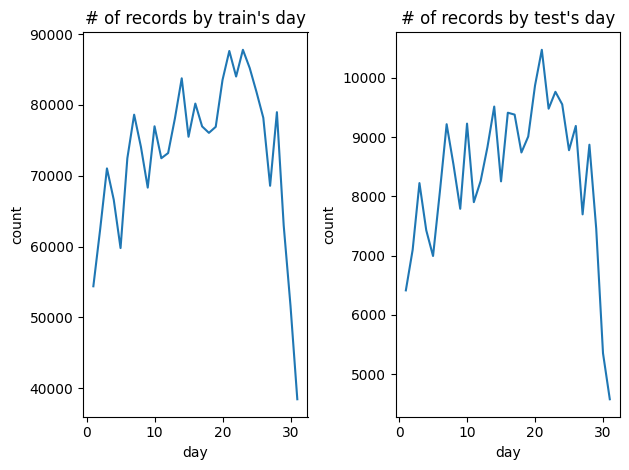

In [520]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2, tight_layout=True)

sns.lineplot(train["day"].value_counts(), ax=axes[0])
axes[0].set_title("# of records by train's day")
             
sns.lineplot(test["day"].value_counts(), ax=axes[1])
axes[1].set_title("# of records by test's day")

**월말로 갈수록 풀이 기록이 많아집니다**

Text(0.5, 1.0, "avg correct rate by test's day")

<Figure size 2000x600 with 0 Axes>

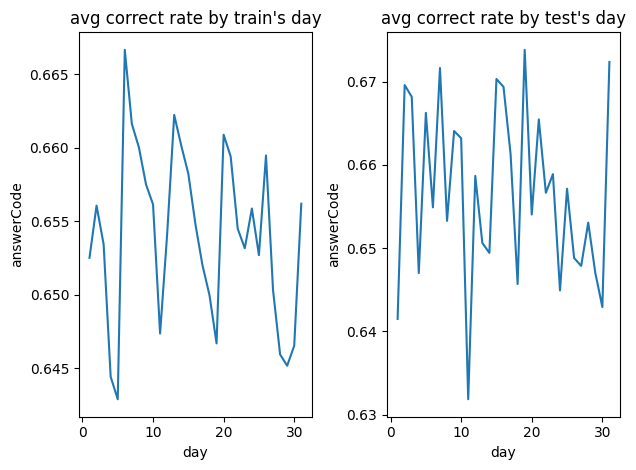

In [518]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2, tight_layout=True)

sns.lineplot(train.groupby(["day"])["answerCode"].mean(), ax=axes[0])
axes[0].set_title("avg correct rate by train's day")
             
sns.lineplot(test.groupby(["day"])["answerCode"].mean(), ax=axes[1])
axes[1].set_title("avg correct rate by test's day")

<Figure size 2000x600 with 0 Axes>

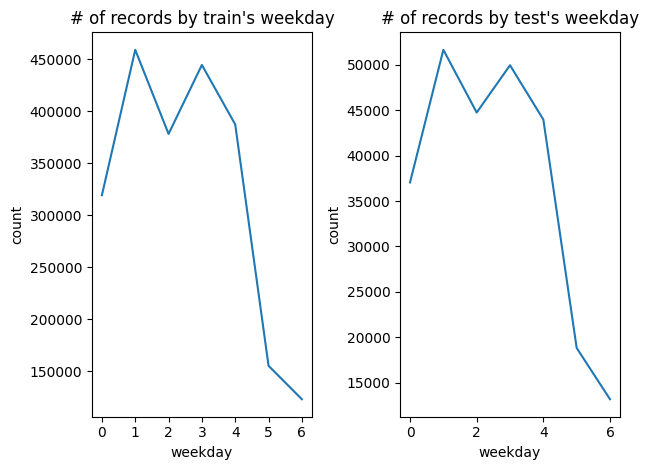

In [525]:
plt.figure(figsize=(20, 6))
fig, axes=plt.subplots(1, 2, tight_layout=True)

sns.lineplot(train["weekday"].value_counts(), ax=axes[0])
axes[0].set_title("# of records by train's weekday")
axes[0].set_xticks(range(7))
             
sns.lineplot(test["weekday"].value_counts(), ax=axes[1])
axes[1].set_title("# of records by test's weekday")
axes[0].set_xticks(range(7))

**주말로 갈수록 풀이 기록이 적습니다**

(정답률과는 큰 상관은 없는 것으로 확인)

<Axes: >

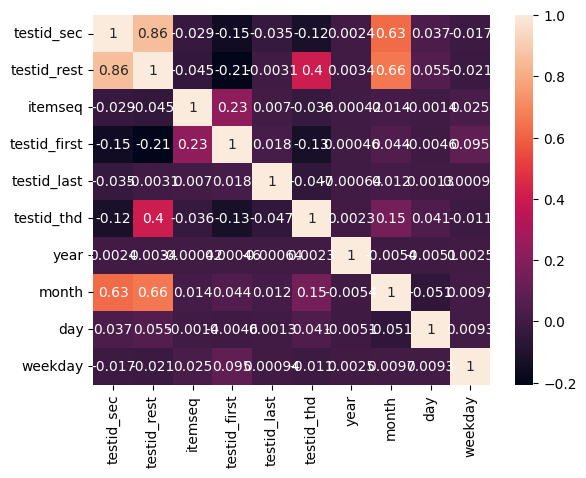

In [534]:
sns.heatmap(train.iloc[:, 6:].corr(), annot=True)

**month와 testid 마지막 3자리가 높은 상관관계를 보입니다**

<Axes: xlabel='month', ylabel='testid_rest'>

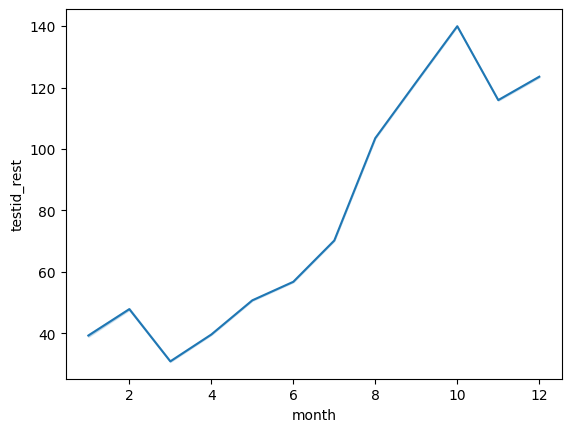

In [540]:
sns.lineplot(x="month", y="testid_rest", data=train)

**testid의 마지막 3자리는 시간순으로 매겨진 것으로 추측됩니다**

In [562]:
train.loc[:, "hour"]=train.loc[:,"Timestamp"].dt.hour
test.loc[:, "hour"]=test.loc[:,"Timestamp"].dt.hour

Text(0.5, 1.0, "# of records by test's hour")

<Figure size 2000x600 with 0 Axes>

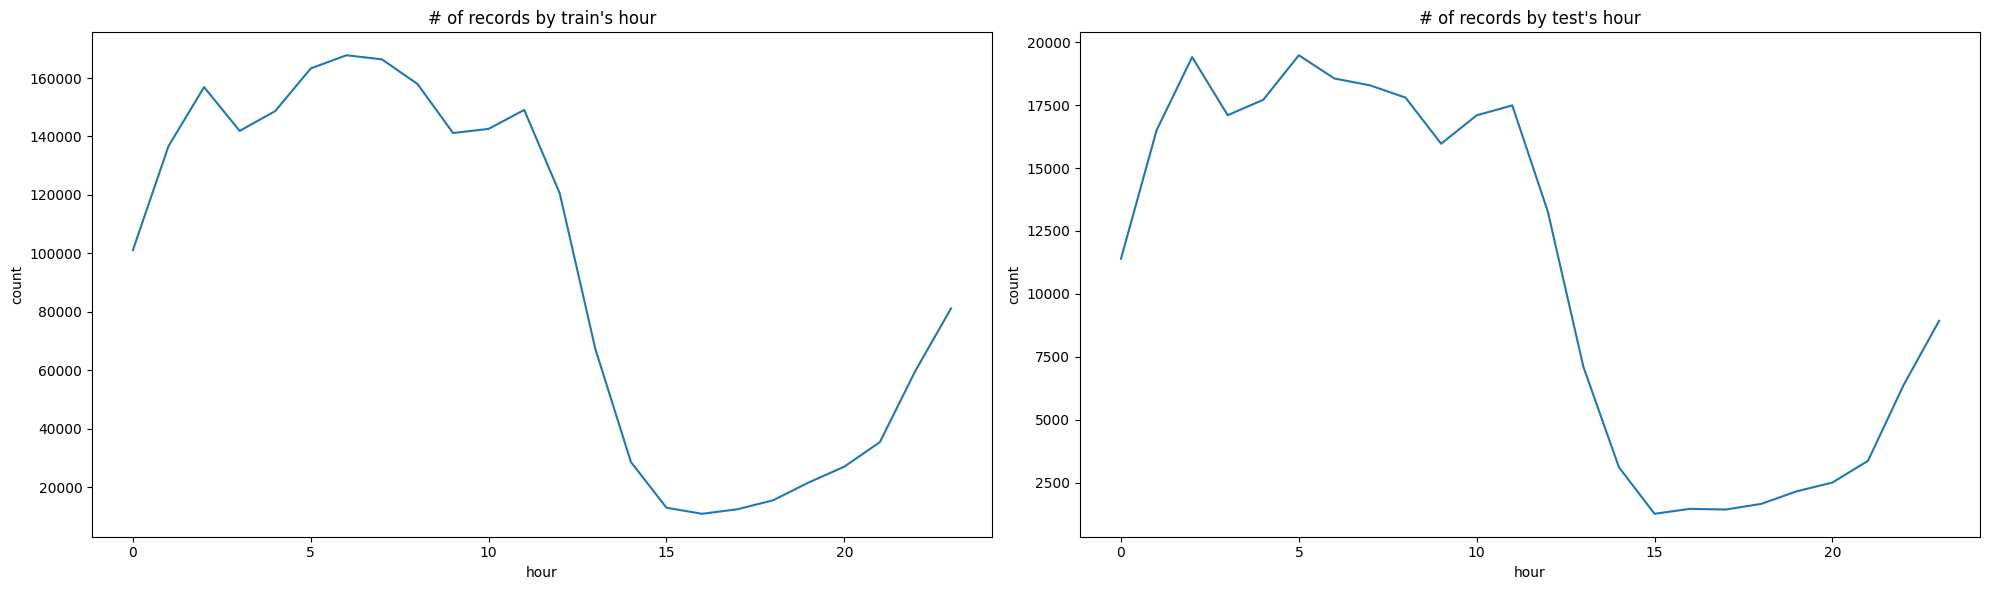

In [564]:
fig, axes=plt.subplots(1, 2, tight_layout=True, figsize=(20, 6))

sns.lineplot(train["hour"].value_counts(), ax=axes[0])
axes[0].set_title("# of records by train's hour")
             
sns.lineplot(test["hour"].value_counts(), ax=axes[1])
axes[1].set_title("# of records by test's hour")

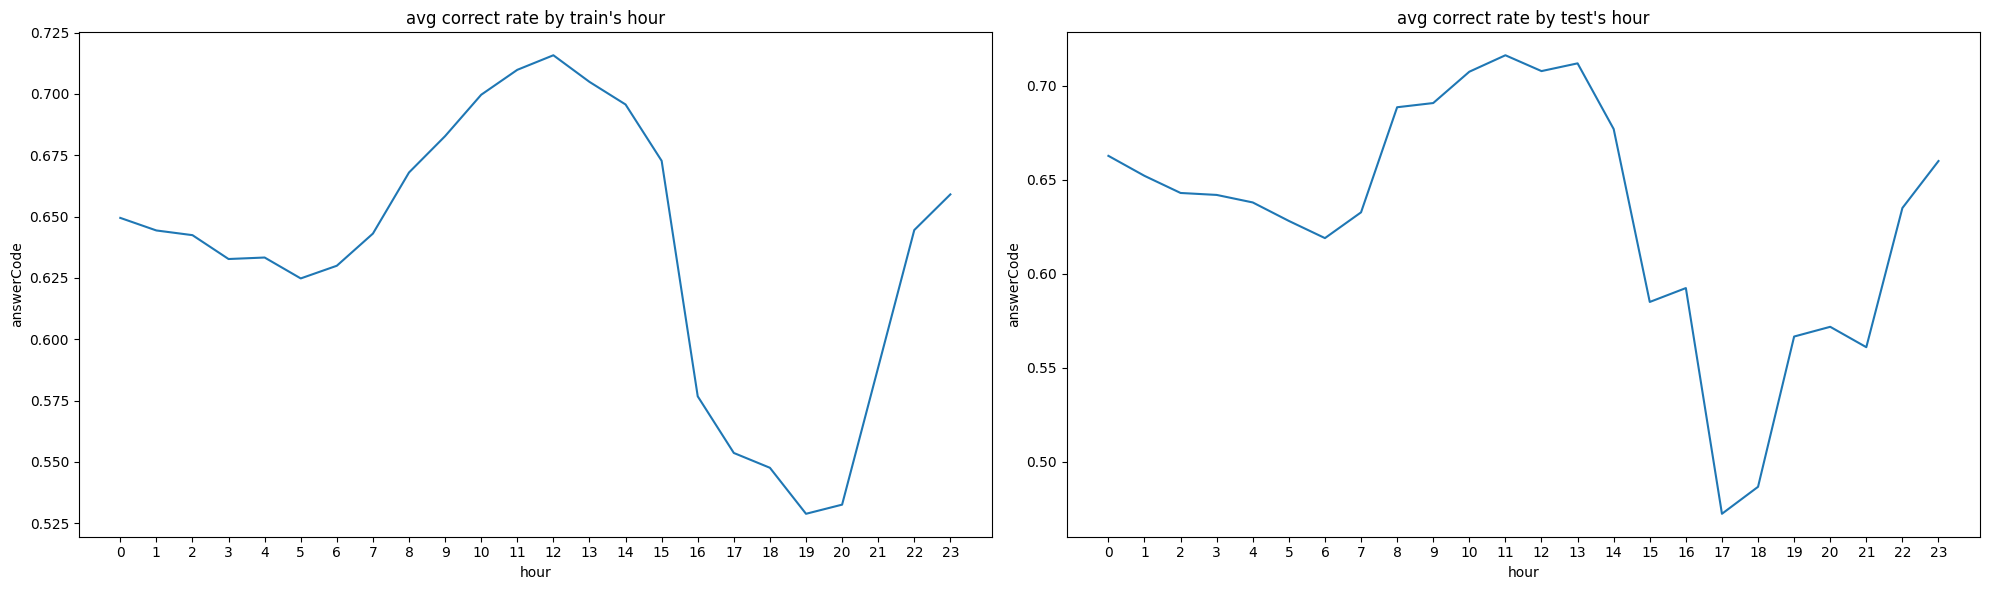

In [573]:
fig, axes=plt.subplots(1, 2, tight_layout=True, figsize=(20, 6))

sns.lineplot(train.groupby(["hour"])["answerCode"].mean(), ax=axes[0])
axes[0].set_title("avg correct rate by train's hour")
axes[0].set_xticks(range(24))
             
sns.lineplot(test.groupby(["hour"])["answerCode"].mean(), ax=axes[1])
axes[1].set_title("avg correct rate by test's hour")
axes[1].set_xticks(range(24))

**train, test 유저 모두 오후 4시-9시까지 정답률이 급감합니다**

**hour를 구간에 따라 0-5/6-12/12-16/16-21/21-24로 나눠볼 수 있습니다**

In [ ]:
def hour_map(x):
    if x < 5:
        return 1
    elif x >= 6 and x < 12:
        return 2
    elif x >= 12 and x < 16:
        return 3
    elif x >= 16 and x < 21:
        return 4
    elif x >= 21 and x < 24:
        return 5

In [820]:
train["repeat"]=train.groupby(["userID", "assessmentItemID"]).cumcount()+1
train["elapse"]=train.groupby(["userID","testId", "repeat"])["Timestamp"].diff().dt.seconds

In [821]:
train["elapse"].describe().astype(int)

count    1893983
mean         119
std         1405
min            0
25%           10
50%           27
75%           65
max        86345
Name: elapse, dtype: int64

/tmp/ipykernel_58986/343651747.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["elapse"].dropna())


<Axes: xlabel='elapse', ylabel='Density'>

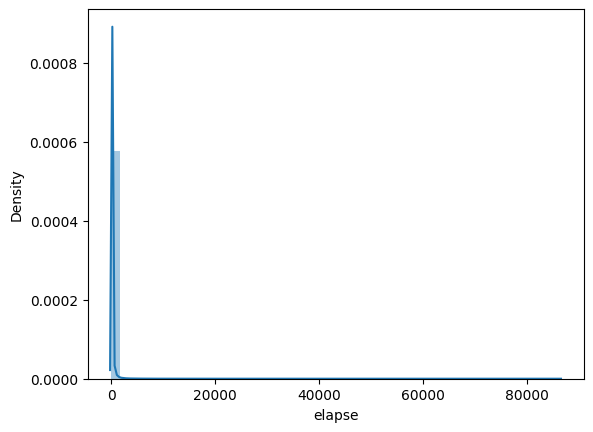

In [822]:
sns.distplot(train["elapse"].dropna())

**문제 풀이 시간이 과도하게 긴 일부 이상치가 존재합니다**

**중간값은 20초입니다**

In [823]:
train.dropna().groupby("answerCode")["elapse"].mean()

answerCode
0     98.555305
1    131.510519
Name: elapse, dtype: float64

정답 기록의 평균 풀이 시간이 더 깁니다

In [824]:
train[train["elapse"]>3600]["answerCode"].mean(), train[train["elapse"]<=3600]["answerCode"].mean()

(0.6860859728506787, 0.6353080645255229)

**1시간 이내보다 1시간 이상 문제 풀이를 한 경우 정답률이 더 높습니다**

In [825]:
train[train["elapse"]>10000]["answerCode"].mean(), train[train["elapse"]<=10000]["answerCode"].mean()

(0.7039223956136651, 0.6353644404877956)

In [965]:
def elapse_map(x):
    if x==float('nan'):
        pass
    elif x < 30:
        return 1
    elif x >= 30 and x < 60:
        return 2
    elif x >= 60 and x < 600:
        return 3
    elif x >= 600 and x < 1800:
        return 4
    elif x >= 1800 and x < 3600:
        return 5
    elif x >= 3600 and x < 10000:
        return 6
    elif x >= 3600 and x < 10000:
        return 7
    elif x >= 10000 and x < 40000:
        return 8
    elif x >= 10000 and x < 80000:
        return 9
    else:
        return 10

In [966]:
train["elapse_bin"]=train["elapse"].apply(elapse_map)

<Axes: xlabel='elapse_bin', ylabel='answerCode'>

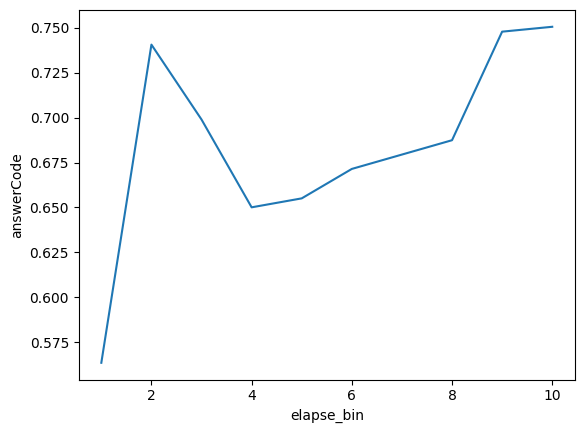

In [967]:
sns.lineplot(train.groupby("elapse_bin")["answerCode"].mean())

**문제 풀이에 걸린 시간이 30초 이내일 경우 정답률이 낮은편입니다**

**30초~1분 사이와 하루 이상이 걸린 경우 정답률이 가장 높습니다**

**10분~1시간 때 정답률이 낮습니다**

In [837]:
train[train["elapse"]>80000]["testid_first"].value_counts()

testid_first
7    64
8    46
9    19
5     3
6     1
2     1
Name: count, dtype: int64

**문제 풀이가 하루가 넘어가는 경우 정답률이 낮은 테스트 그룹(7, 8, 9)가 많습니다**

**어려워서 공부를 더 하고 문제를 푸는 경우라고 추측해볼 수 있음?**

In [838]:
test["repeat"]=test.groupby(["userID", "assessmentItemID"]).cumcount()+1
test["elapse"]=test.groupby(["userID","testId", "repeat"])["Timestamp"].diff().dt.seconds
test["elapse"].describe().astype(int)

count    216673
mean        118
std        1410
min           0
25%          10
50%          27
75%          65
max       85520
Name: elapse, dtype: int64

/tmp/ipykernel_58986/1717495832.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test["elapse"].dropna())


<Axes: xlabel='elapse', ylabel='Density'>

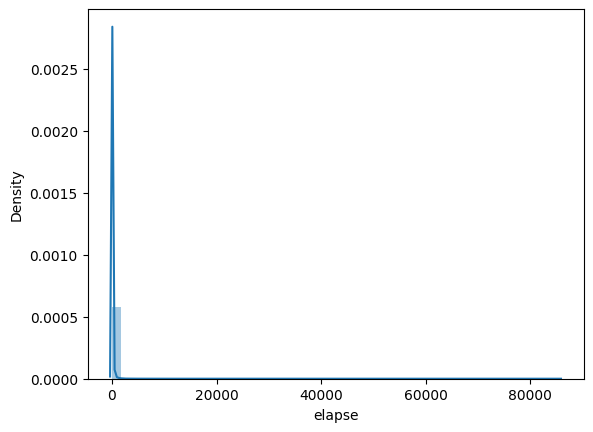

In [839]:
sns.distplot(test["elapse"].dropna())

In [840]:
test.dropna().groupby("answerCode")["elapse"].mean()

answerCode
0    102.602959
1    128.096532
Name: elapse, dtype: float64

In [841]:
test[test["elapse"]>3600]["answerCode"].mean(), test[test["elapse"]<=3600]["answerCode"].mean()

(0.6700507614213198, 0.638660323395748)

<Axes: xlabel='elapse_bin', ylabel='answerCode'>

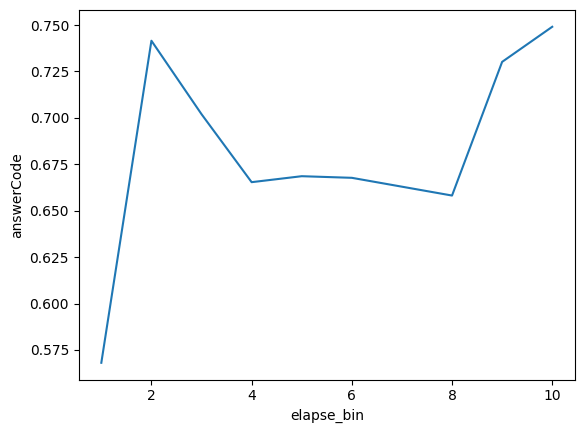

In [842]:
test["elapse_bin"]=test["elapse"].apply(elapse_map)
sns.lineplot(test.groupby("elapse_bin")["answerCode"].mean())

**test data 역시 비슷한 경향을 보입니다**

In [818]:
test[test["elapse"]>80000]["testid_first"].value_counts()

testid_first
7    10
8     3
9     1
Name: count, dtype: int64

## 5. repeat 관련

In [757]:
train.groupby(["repeat"])["answerCode"].mean()

repeat
1    0.654647
2    0.645138
3    0.438849
Name: answerCode, dtype: float64

In [766]:
train.groupby(["repeat"])["testid_first"].mean()

repeat
1    4.701168
2    4.844456
3    7.119904
Name: testid_first, dtype: object

**train의 경우 복습횟수가 늘어날수록 정답률이 떨어집니다**

**난이도가 높은 시험지를 복습하는 경향성**

In [748]:
test.groupby(["repeat"])["answerCode"].mean()

repeat
1    0.656640
2    0.674225
3    0.666667
Name: answerCode, dtype: float64

In [763]:
test.groupby(["repeat"])["testid_first"].mean()

repeat
1    4.707638
2    4.576972
3         9.0
Name: testid_first, dtype: object

## 6. user_acc 관련

In [983]:
train['user_correct_answer'] = train.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
train['user_total_answer'] = train.groupby('userID')['answerCode'].cumcount()
train['user_acc'] = train['user_correct_answer']/train['user_total_answer']

test['user_correct_answer'] = test.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
test['user_total_answer'] = test.groupby('userID')['answerCode'].cumcount()
test['user_acc'] = test['user_correct_answer']/train['user_total_answer']

<Axes: xlabel='user_acc', ylabel='Count'>

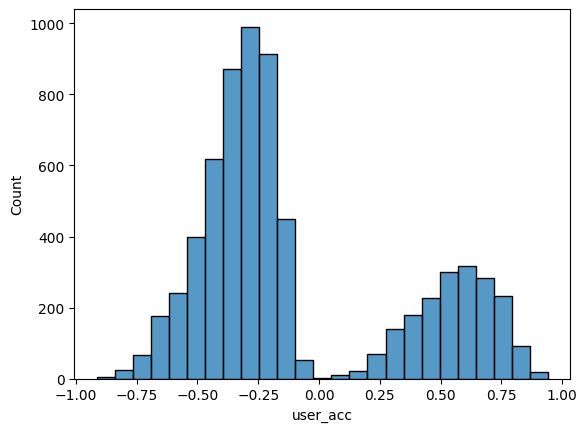

In [986]:
sns.histplot(train.groupby(["userID"])["user_acc"].last()-train.groupby(["userID"])["user_acc"].first())

In [969]:
train['user_test_correct_answer'] = train.groupby(['userID', 'testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
train['user_test_total_answer'] = train.groupby(['userID', 'testId'])['answerCode'].cumcount()
train['user_test_acc'] = train['user_test_correct_answer']/train['user_test_total_answer']

<Axes: >

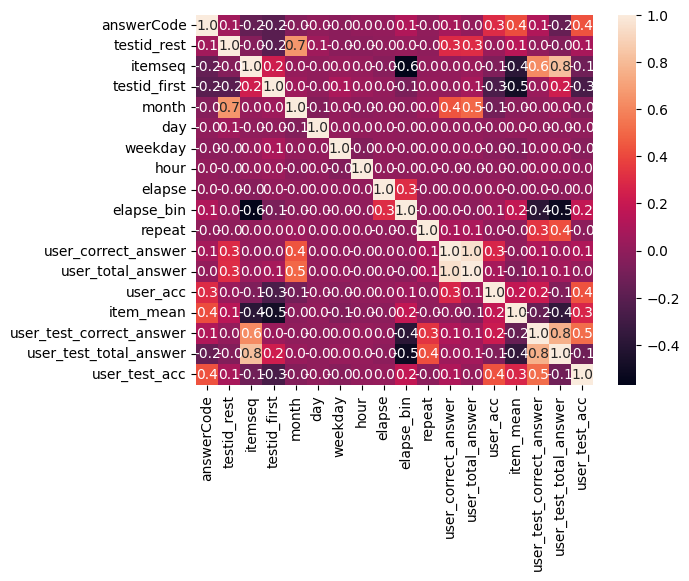

In [975]:
sns.heatmap(train[['answerCode', 'testid_rest', 'itemseq', 'testid_first',
       'month', 'day', 'weekday', 'hour',
       'elapse', 'elapse_bin', 'repeat', 'user_correct_answer',
       'user_total_answer', 'user_acc', 'item_mean', 
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc']].corr(), annot=True, fmt=".1f")

<Axes: xlabel='user_test_acc', ylabel='Count'>

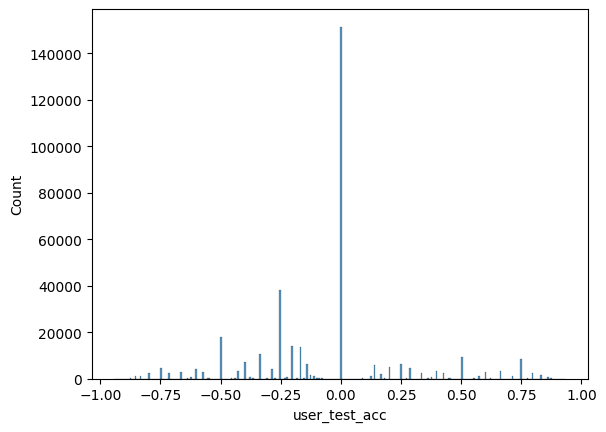

In [976]:
sns.histplot(train.groupby(["userID", "testId"])["user_test_acc"].last()-train.groupby(["userID", "testId"])["user_test_acc"].first())

In [977]:
train['user_tag_correct_answer'] = train.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
train['user_tag_total_answer'] = train.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumcount()
train['user_tag_acc'] = train['user_tag_correct_answer']/train['user_tag_total_answer']

<Axes: >

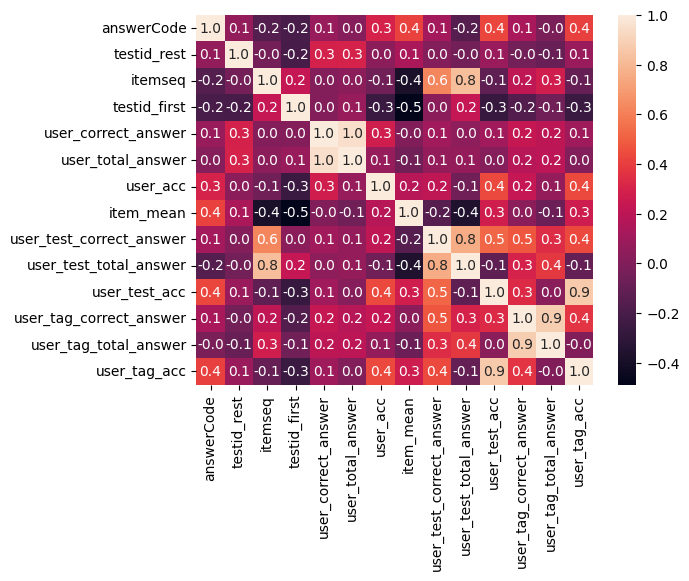

In [979]:
sns.heatmap(train[['answerCode', 'testid_rest', 'itemseq', 'testid_first', 
                   'user_correct_answer','user_total_answer', 'user_acc', 'item_mean', 
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc', 
        "user_tag_correct_answer", "user_tag_total_answer", "user_tag_acc"]].corr(), annot=True, fmt=".1f")

<Axes: xlabel='user_tag_acc', ylabel='Count'>

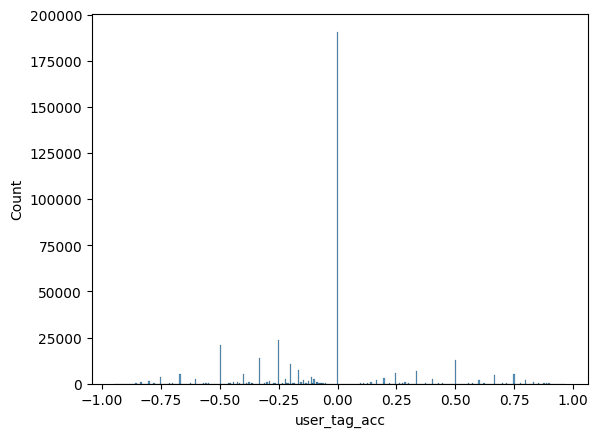

In [980]:
sns.histplot(train.groupby(["userID", "KnowledgeTag"])["user_tag_acc"].last()-train.groupby(["userID", "KnowledgeTag"])["user_tag_acc"].first())

In [981]:
test['user_test_correct_answer'] = test.groupby(['userID', 'testId'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
test['user_test_total_answer'] = test.groupby(['userID', 'testId'])['answerCode'].cumcount()
test['user_test_acc'] = test['user_test_correct_answer']/test['user_test_total_answer']

<Axes: >

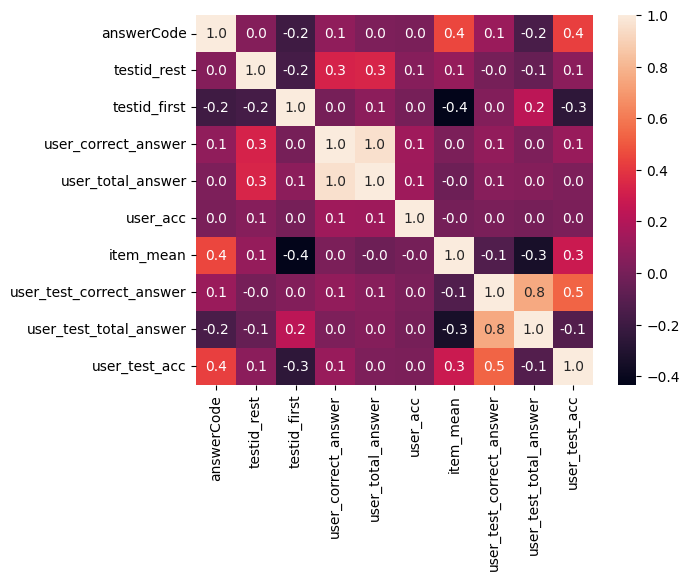

In [985]:
sns.heatmap(test[['answerCode', 'testid_rest', 'testid_first',
       'user_correct_answer', 'user_total_answer', 'user_acc', 'item_mean', 
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc']].corr(), annot=True, fmt=".1f")

In [989]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_first,year,month,...,elapse_bin,item_mean,relative_acc,testid_rest,user_test_correct_answer,user_test_total_answer,user_test_acc,user_correct_answer,user_total_answer,user_acc
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,5,2020,1,...,10,0.750000,0.250000,023,0.0,0,NaN,NaN,0,NaN
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,5,2020,1,...,1,0.562500,0.437500,023,1.0,1,1.000000,1.0,1,1.000000
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,5,2020,1,...,3,0.343750,-0.343750,023,2.0,2,1.000000,2.0,2,1.000000
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,5,2020,1,...,1,0.500000,-0.500000,023,2.0,3,0.666667,2.0,3,0.666667
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,5,2020,1,...,1,0.281250,-0.281250,023,2.0,4,0.500000,2.0,4,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,4,2020,8,...,1,1.000000,0.000000,197,3.0,5,0.600000,7.0,10,0.076087
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,4,2020,10,...,10,0.380952,-0.380952,130,0.0,0,NaN,8.0,11,0.086022
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,4,2020,10,...,1,0.523810,0.476190,130,0.0,1,0.000000,8.0,12,0.085106
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,4,2020,10,...,1,0.761905,0.238095,130,1.0,2,0.500000,9.0,13,0.094737


<Axes: xlabel='user_test_acc', ylabel='Count'>

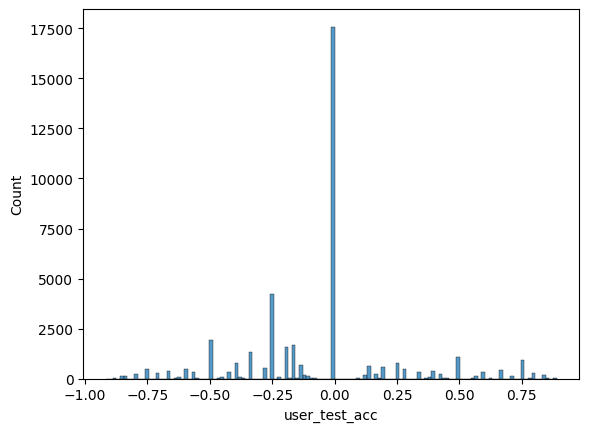

In [990]:
sns.histplot(test.groupby(["userID", "testId"])["user_test_acc"].last()-test.groupby(["userID", "testId"])["user_test_acc"].first())

In [992]:
test['user_tag_correct_answer'] = test.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.cumsum().shift(1)).fillna(0)
test['user_tag_total_answer'] = test.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumcount()
test['user_tag_acc'] = test['user_tag_correct_answer']/test['user_tag_total_answer']

<Axes: >

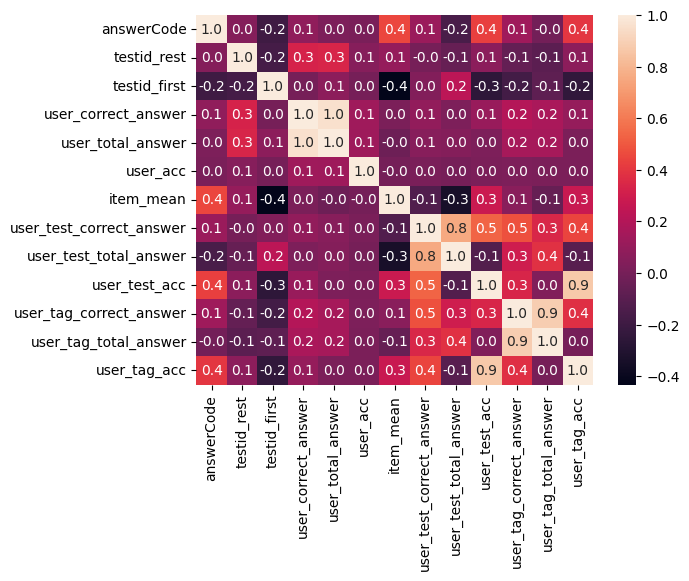

In [995]:
sns.heatmap(test[['answerCode', 'testid_rest',  'testid_first', 
                   'user_correct_answer','user_total_answer', 'user_acc', 'item_mean', 
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc', 
        "user_tag_correct_answer", "user_tag_total_answer", "user_tag_acc"]].corr(), annot=True, fmt=".1f")

**test에서는 user_acc가 큰 상관이 없어보입니다 -> drop** 

In [1003]:
item_std=train.groupby("assessmentItemID")["answerCode"].std().to_dict()
train["item_std"]=train["assessmentItemID"].map(item_std)

In [1004]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first,...,user_acc,item_mean,user_tag_mean,user_test_correct_answer,user_test_total_answer,user_test_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,item_std
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,001,1,6,...,NaN,0.982063,1.0,0.0,0,NaN,0.0,0,NaN,0.133022
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,001,2,6,...,1.000000,0.964126,1.0,1.0,1,1.00,0.0,0,NaN,0.186395
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,001,3,6,...,1.000000,0.910314,1.0,2.0,2,1.00,1.0,1,1.00,0.286374
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,001,4,6,...,1.000000,0.968610,1.0,3.0,3,1.00,2.0,2,1.00,0.174762
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,001,5,6,...,1.000000,0.941704,1.0,4.0,4,1.00,3.0,3,1.00,0.234829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0,071,5,3,...,0.250000,0.435252,0.2,1.0,4,0.25,1.0,4,0.25,0.496684
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,165,1,4,...,0.200000,0.649635,1.0,0.0,0,NaN,0.0,0,NaN,0.477957
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,165,2,4,...,0.333333,0.635036,1.0,1.0,1,1.00,1.0,1,1.00,0.482301
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,165,3,4,...,0.428571,0.791971,1.0,2.0,2,1.00,2.0,2,1.00,0.406641


<Axes: >

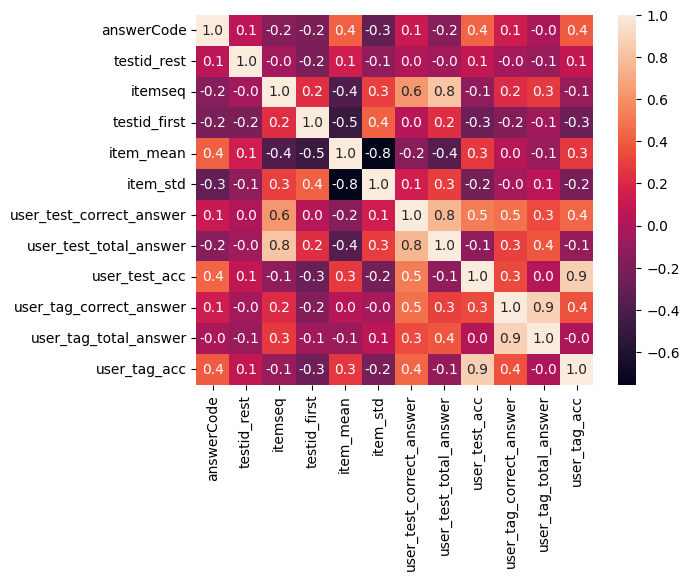

In [1006]:
sns.heatmap(train[['answerCode', 'testid_rest', 'itemseq', 'testid_first', 
                    'item_mean', "item_std",
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc', 
        "user_tag_correct_answer", "user_tag_total_answer", "user_tag_acc"]].corr(), annot=True, fmt=".1f")

In [1007]:
item_std=test.groupby("assessmentItemID")["answerCode"].std().to_dict()
test["item_std"]=test["assessmentItemID"].map(item_std)

In [1008]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_first,year,month,...,user_test_correct_answer,user_test_total_answer,user_test_acc,user_correct_answer,user_total_answer,user_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,item_std
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,5,2020,1,...,0.0,0,NaN,NaN,0,NaN,0.0,0,NaN,0.439941
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,5,2020,1,...,1.0,1,1.000000,1.0,1,1.000000,1.0,1,1.0,0.504016
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,5,2020,1,...,2.0,2,1.000000,2.0,2,1.000000,0.0,0,NaN,0.482559
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,5,2020,1,...,2.0,3,0.666667,2.0,3,0.666667,0.0,1,0.0,0.508001
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,5,2020,1,...,2.0,4,0.500000,2.0,4,0.500000,0.0,0,NaN,0.456803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,4,2020,8,...,3.0,5,0.600000,7.0,10,0.076087,3.0,5,0.6,0.000000
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,4,2020,10,...,0.0,0,NaN,8.0,11,0.086022,0.0,0,NaN,0.491507
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,4,2020,10,...,0.0,1,0.000000,8.0,12,0.085106,0.0,1,0.0,0.505487
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,4,2020,10,...,1.0,2,0.500000,9.0,13,0.094737,0.0,0,NaN,0.431081


<Axes: >

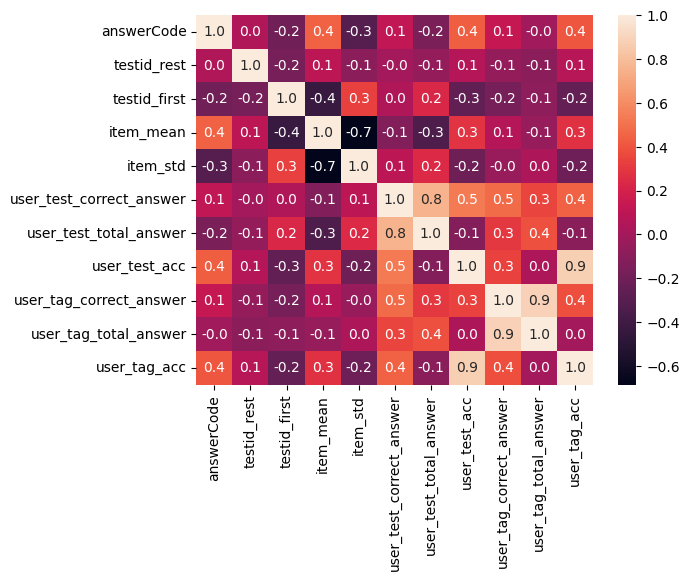

In [1010]:
sns.heatmap(test[['answerCode', 'testid_rest', 'testid_first', 
                    'item_mean', "item_std",
       'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc', 
        "user_tag_correct_answer", "user_tag_total_answer", "user_tag_acc"]].corr(), annot=True, fmt=".1f")

In [1011]:
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_first,year,month,...,user_test_correct_answer,user_test_total_answer,user_test_acc,user_correct_answer,user_total_answer,user_acc,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,item_std
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,5,2020,1,...,0.0,0,NaN,NaN,0,NaN,0.0,0,NaN,0.439941
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,5,2020,1,...,1.0,1,1.000000,1.0,1,1.000000,1.0,1,1.0,0.504016
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,5,2020,1,...,2.0,2,1.000000,2.0,2,1.000000,0.0,0,NaN,0.482559
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,5,2020,1,...,2.0,3,0.666667,2.0,3,0.666667,0.0,1,0.0,0.508001
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,5,2020,1,...,2.0,4,0.500000,2.0,4,0.500000,0.0,0,NaN,0.456803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,4,2020,8,...,3.0,5,0.600000,7.0,10,0.076087,3.0,5,0.6,0.000000
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,4,2020,10,...,0.0,0,NaN,8.0,11,0.086022,0.0,0,NaN,0.491507
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,4,2020,10,...,0.0,1,0.000000,8.0,12,0.085106,0.0,1,0.0,0.505487
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,4,2020,10,...,1.0,2,0.500000,9.0,13,0.094737,0.0,0,NaN,0.431081


In [1034]:
train["correct_test_future"]=train.groupby(["userID", "testId"])["answerCode"].shift(-1)
train["correct_test_past"]=train.groupby(["userID", "testId"])["answerCode"].shift(1).fillna(0)
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_rest,itemseq,testid_first,...,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,item_std,correct_future,correct_past,correct_tag_future,correct_tag_past,correct_test_future,correct_test_past
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,001,1,6,...,0.0,0,NaN,0.133022,1.0,0.0,1.0,0.0,1.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0,001,2,6,...,0.0,0,NaN,0.186395,1.0,1.0,1.0,1.0,1.0,1.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0,001,3,6,...,1.0,1,1.00,0.286374,1.0,1.0,1.0,1.0,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0,001,4,6,...,2.0,2,1.00,0.174762,1.0,1.0,1.0,1.0,1.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0,001,5,6,...,3.0,3,1.00,0.234829,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0,071,5,3,...,1.0,4,0.25,0.496684,1.0,0.0,NaN,0.0,NaN,0.0
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,165,1,4,...,0.0,0,NaN,0.477957,1.0,0.0,1.0,0.0,1.0,0.0
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,1,165,2,4,...,1.0,1,1.00,0.482301,1.0,1.0,1.0,1.0,1.0,1.0
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,1,165,3,4,...,2.0,2,1.00,0.406641,1.0,1.0,1.0,1.0,1.0,1.0


<Axes: >

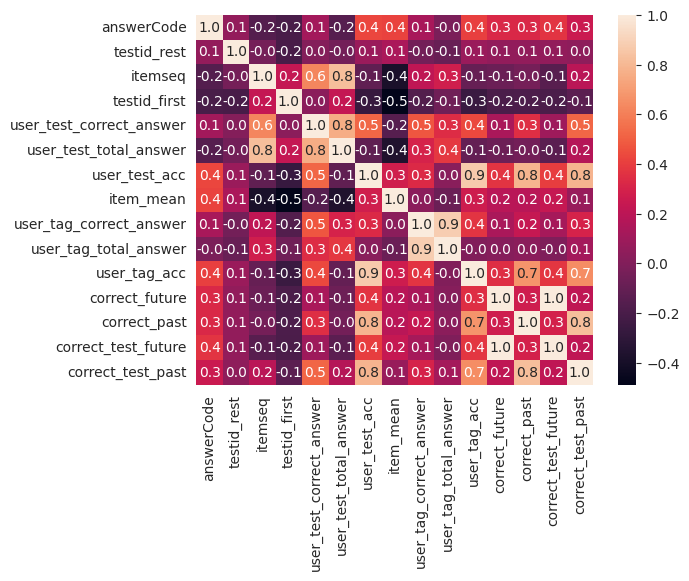

In [1035]:
sns.heatmap(train[['answerCode', 'testid_rest', 'itemseq', 'testid_first', 'user_test_correct_answer', 'user_test_total_answer', 'user_test_acc',
                   'item_mean',  "user_tag_correct_answer", "user_tag_total_answer", "user_tag_acc", 
                   "correct_future", "correct_past", "correct_test_future", "correct_test_past"]].corr(), annot=True, fmt=".1f")

In [1036]:
test["correct_test_future"]=test.groupby(["userID", "testId"])["answerCode"].shift(-1)
test["correct_test_past"]=test.groupby(["userID", "testId"])["answerCode"].shift(1).fillna(0)
test

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,testid_sec,testid_first,year,month,...,user_tag_correct_answer,user_tag_total_answer,user_tag_acc,item_std,correct_future,correct_past,correct_tag_future,correct_tag_past,correct_test_future,correct_test_past
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,5,2020,1,...,0.0,0,NaN,0.439941,1.0,0.0,1.0,0.0,1.0,0.0
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,5,2020,1,...,1.0,1,1.0,0.504016,0.0,1.0,0.0,1.0,0.0,1.0
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,5,2020,1,...,0.0,0,NaN,0.482559,0.0,1.0,0.0,0.0,0.0,1.0
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,5,2020,1,...,0.0,1,0.0,0.508001,0.0,0.0,0.0,0.0,0.0,0.0
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,5,2020,1,...,0.0,0,NaN,0.456803,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260108,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,4,2020,8,...,3.0,5,0.6,0.000000,0.0,0.0,NaN,0.0,NaN,0.0
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,4,2020,10,...,0.0,0,NaN,0.491507,1.0,1.0,1.0,0.0,1.0,0.0
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,4,2020,10,...,0.0,1,0.0,0.505487,1.0,0.0,NaN,0.0,1.0,0.0
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,4,2020,10,...,0.0,0,NaN,0.431081,1.0,1.0,1.0,0.0,1.0,1.0


<Axes: >

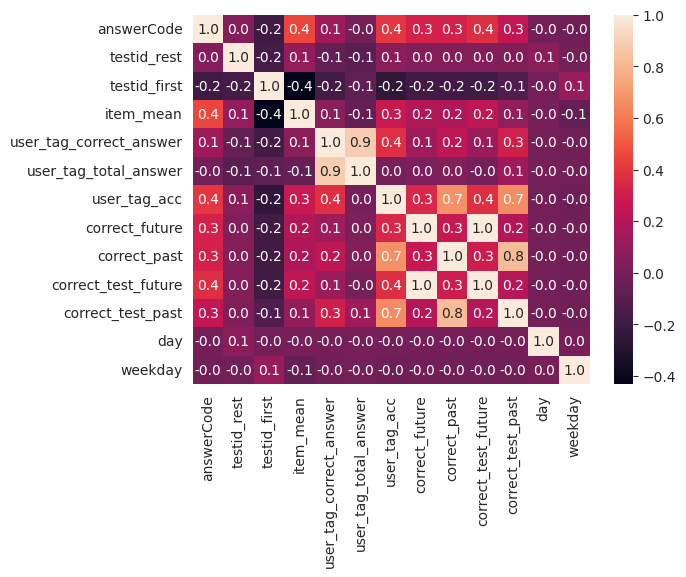

In [1039]:
sns.heatmap(test[['answerCode', 'testid_rest', 'testid_first', 
                   'item_mean', "user_tag_correct_answer", "user_tag_total_answer", 
                  "user_tag_acc", "correct_future", "correct_past", "correct_test_future", "correct_test_past", 'day', 'weekday']].corr(), annot=True, fmt=".1f")